# Gridpatcher
J. R. Angevaare <joran.angevaare@knmi.nl>

2025 03 13
last update: 2025 04 30

## Preamble
This tutorial is meant to explain the `DiscontinuousGridPatcher` introduced in https://github.com/JoranAngevaare/optim_esm_tools/pull/223.

This tutorial should only be followed **after** the **example.ipynb** tutorial in the same folder.

## Imports, machine setup

In [1]:
start = !date

In [2]:
import optim_esm_tools as oet
import os
import numpy as np


import matplotlib.pyplot as plt
import glob
import pandas as pd
import logging
import tempfile
import datetime
import xarray as xr
from IPython.utils import io

In [3]:
logger = oet.get_logger('EXAMPLE')
logger.setLevel(logging.WARNING)

Let's print some relevant versions

In [4]:
oet.print_versions(
    'optim_esm_tools cartopy numpy numba matplotlib'.split(), print_output=False
)

,module,version,path,git
0,python,3.8.16,/home/aangevaare/miniconda3/envs/py38/bin/python,None
1,optim_esm_tools,4.0.0,/home/aangevaare/software/optim_esm_tools/opti...,branch:advanced_examples | fc5702b
2,cartopy,0.21.0,/home/aangevaare/miniconda3/envs/py38/lib/pyth...,None
3,numpy,1.24.3,/home/aangevaare/miniconda3/envs/py38/lib/pyth...,None
4,numba,0.57.1,/home/aangevaare/miniconda3/envs/py38/lib/pyth...,None
5,matplotlib,None,/home/aangevaare/miniconda3/envs/py38/lib/pyth...,None


## 0. Data preperation

First we need to setup some method of obtaining data. We'll just provide one working example, but for a large scale application one has to make use of tools like `synda`, `ESGF`, `esgpull` or `intake-esm`.


### Download some example data using `intake-esm`
Below we use `intake-esm` to download one MOHC dataset.

It's advisable to use the ESGF folder structure as some subroutines are based on that. It's not essential, but does make things easier.

In [5]:
col = oet._test_utils.cmip_store()

we will download one dataset (SSP585, historical and pi-control) and store it in the `WORK_DIR`

In [6]:
WORK_DIR = "/data/volume_2/temp/example_notebook_v4"

if not os.path.exists(WORK_DIR):
    WORK_DIR = tempfile.mkdtemp()
    logger.warning(f"Using {WORK_DIR} you may have limited space here")

In [7]:
query = dict(
    variable_id="sos",
    table_id="Omon",
    source_id="IPSL-CM6A-LR",
    member_id=[
        "r1i1p1f1",
    ],
    experiment_id=[
        "ssp585",
    ],
)

In [8]:
with io.capture_output() as captured:
    search = col.search(**query)

In [9]:
search.keys_info()

,activity_id,institution_id,source_id,experiment_id,table_id,grid_label
key,,,,,,
ScenarioMIP.IPSL.IPSL-CM6A-LR.ssp585.Omon.gn,ScenarioMIP,IPSL,IPSL-CM6A-LR,ssp585,Omon,gn


In [ ]:
with io.capture_output() as captured:
    ddict = search.to_dataset_dict(
        xarray_open_kwargs={"use_cftime": True},
    )

load py-cdo - if we are writing the files we use CDO to calculate the yearly means

In [11]:
import cdo as cdo_module

cdo = cdo_module.Cdo()

### First data preperation: yearly averaging
We first take the yearly averages of the data. That makes the data much lighter and easer to handle.

We store the zar-files to disk and then calculate the yearly averages.

In [12]:
folders = {}
for key, data in ddict.items():
    folder_structure = key.split(".")
    folder_structure.insert(4, "{VARIANT_LABEL}")
    folder_structure.insert(6, "{VARIABLE_ID}")
    folder_structure.append("v20241126")

    path_fmt = os.path.join(WORK_DIR, *folder_structure)

    for variant_label in np.unique(data["member_id"]):
        ds = data.sel(member_id=variant_label)
        ds = ds.isel(dcpp_init_year=0)

        os.makedirs(
            save_in := path_fmt.format(
                VARIANT_LABEL=variant_label, VARIABLE_ID=ds.attrs["variable_id"]
            ),
            exist_ok=True,
        )

        logger.warning(f"Writing {key} to {save_in}")
        folders[f"{key}.{variant_label}"] = save_in

        if os.path.exists(yearly_file := os.path.join(save_in, "merged.nc")):
            continue
        if not os.path.exists(monthly_file := os.path.join(save_in, "monthly.nc")):
            ds.to_netcdf(monthly_file)
        cdo.yearmonmean(input=monthly_file, output=yearly_file)
        for f in monthly_file, yearly_file:
            assert os.path.exists(f), f"Missing {f}"

04-30 12:03:42 | EXAMPLE      | WARNING  | Writing ScenarioMIP.IPSL.IPSL-CM6A-LR.ssp585.Omon.gn to /data/volume_2/temp/example_notebook_v4/ScenarioMIP/IPSL/IPSL-CM6A-LR/ssp585/r1i1p1f1/Omon/sos/gn/v20241126 | <module> (l. 21)


### Folders in WORK_DIR
You can now examine the folfders in `WORK_DIR`, let's see that there are indeed files there

In [13]:
!ls $WORK_DIR/*/*/IPSL-CM6A-LR/*/*/*/*/*/* -lthra

for monthly_file in glob.glob(f'{WORK_DIR}/*/*/IPSL-CM6A-LR/*/*/*/*/*/*/monthly.nc'):
    logger.warning(f'Removing {monthly_file} - we don\'t need it anymore')
    os.remove(monthly_file)

total 279M
drwxrwxr-x 3 aangevaare aangevaare   31 Mar 13 11:48 ..
-rw-rw-r-- 1 aangevaare aangevaare  45M Mar 13 11:54 merged.nc
-rw-rw-r-- 1 aangevaare aangevaare  20M Mar 13 11:54 sos_s_e_ma10_optimesm_v0.8.2_n90.nc
-rw-rw-r-- 1 aangevaare aangevaare  56M Mar 13 11:55 sos_s_e_ma10_hist_optimesm_v0.8.2_n90.nc
-rw-rw-r-- 1 aangevaare aangevaare  41M Mar 13 12:15 sos_s_e_ma10_optimesm_vnotebook_v4.nc
drwxrwxr-x 2 aangevaare aangevaare  233 Mar 13 12:15 .
-rw-rw-r-- 1 aangevaare aangevaare 119M Mar 13 12:15 sos_s_e_ma10_hist_optimesm_vnotebook_v4.nc


## Settings for this notebook

In [14]:
oet.config.config.read_dict({'analyze': {'regrid_to': 'n90'},
                             'versions': {'cmip_handler': 'notebook_v4'}
                            })

In [15]:
# For this example, we will only use the scenario dataset.
ds_ssp = oet.read_ds(
    folders["ScenarioMIP.IPSL.IPSL-CM6A-LR.ssp585.Omon.gn.r1i1p1f1"],
    add_history=False,
    max_time=None,
)

## The issues after regridding with `CDO`

Below we illustrate the issue with regridding this data with CDO. We end up with three blind spots where allegedly there would be no data. This can be an issues in the region finding as we will demonstrate below.

Text(0.5, 1.0, 'Issues after regridding data with discontinuity in ocean locations')

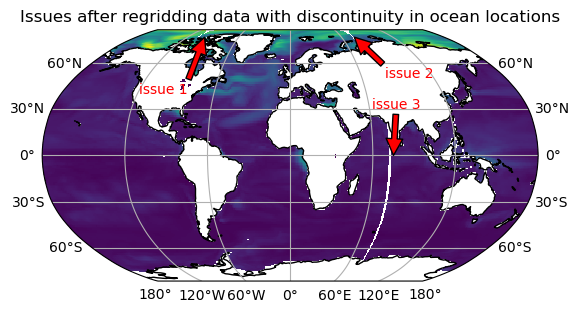

In [16]:
oet.plotting.plot.plot_da(ds_ssp['max jump'], add_colorbar=False)
ax = plt.gca()
annotate_kw = dict(arrowprops=dict(facecolor='red'),
                   color='red',
                   ha='center',
                   transform=oet.plotting.plot.get_cartopy_transform(),
                  )
plt.annotate('issue 1', (-100, 80), (-100, 40), **annotate_kw)
plt.annotate('issue 2', (75, 80), (100, 50), **annotate_kw)
plt.annotate('issue 3', (75, 0), (80, 30), **annotate_kw)
plt.title('Issues after regridding data with discontinuity in ocean locations')

### Solving the issues
We need to solve these issues. We want to fill these nan-values (white regions in the above plot) with something that is reasonable that we can use during the regions finding. 

**However**, most of the white regions (nan-values) are land, which should remain nan-valued for this ocean-salinity values. Therefore, we should be able to tell where there should roughly be portions of data. We roughly mask these regions below

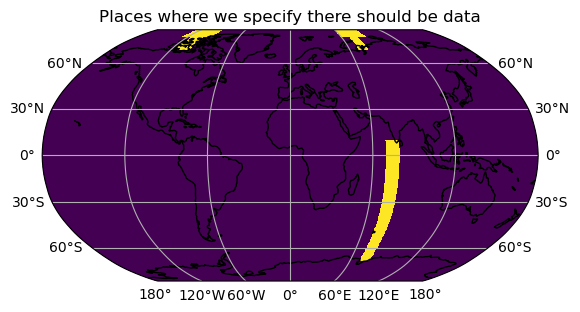

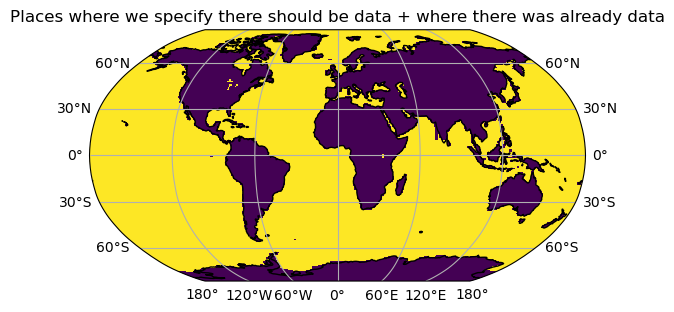

In [17]:
should_have_data = xr.zeros_like(ds_ssp['max jump']).astype(bool)
should_have_data.data[:20,70:80] = 2
should_have_data.data[:10,60:90] = 2

should_have_data.data[:20,245:260] = 2
should_have_data.data[:10,235:270] = 2

should_have_data.data[80:160,70:80] = 2
oet.plotting.plot.plot_da(should_have_data, add_colorbar=False)
plt.title('Places where we specify there should be data')
plt.show()
should_have_data = should_have_data | ~np.isnan(ds_ssp['max jump'])
oet.plotting.plot.plot_da(should_have_data, add_colorbar=False)
plt.title('Places where we specify there should be data + where there was already data')
plt.show()


together with the original dataset, this should be enough to fill the empty regions where data is missing

In [18]:
patcher = oet.analyze.discontinuous_grid_patcher.DiscontinuousGridPatcher(
    ds=ds_ssp,
    should_have_data_mask=should_have_data
)
ds_ssp_patched = patcher.patch_all_issues()

04-30 12:03:51 | oet          | WARNING  | Finding 3 issues. N=[162, 87, 81]. | patch_all_issues (l. 202)


patching issues:   0%|          | 0/3 [00:00<?, ?it/s]

/home/aangevaare/software/optim_esm_tools/optim_esm_tools/analyze/discontinuous_grid_patcher.py:143: RuntimeWarning: Mean of empty slice
  patch_data = np.nanmean(temp, axis=idx_lon)
/home/aangevaare/software/optim_esm_tools/optim_esm_tools/analyze/discontinuous_grid_patcher.py:133: RuntimeWarning: Mean of empty slice
  patch_data = np.nanmean(temp, axis=idx_lon)
/home/aangevaare/software/optim_esm_tools/optim_esm_tools/analyze/discontinuous_grid_patcher.py:143: RuntimeWarning: Mean of empty slice
  patch_data = np.nanmean(temp, axis=idx_lon)
/home/aangevaare/software/optim_esm_tools/optim_esm_tools/analyze/discontinuous_grid_patcher.py:143: RuntimeWarning: Mean of empty slice
  patch_data = np.nanmean(temp, axis=idx_lon)
/home/aangevaare/software/optim_esm_tools/optim_esm_tools/analyze/discontinuous_grid_patcher.py:133: RuntimeWarning: Mean of empty slice
  patch_data = np.nanmean(temp, axis=idx_lon)


please note that the `oet.analyze.discontinuous_grid_patcher.DiscontinuousGridPatcher` was optimized to run for an `n90` grid. When running with a differnt grid-configuration, one might have to change the parameters in the patcher, see for example:

In [19]:
patcher.min_samples_for_issue, patcher.build_cluster_kw, patcher.split_cluster_kw

(75,
 {'min_samples': 4, 'max_distance_km': 120},
 {'add_diagonal': False, 'add_double_lon': False})

### Checking where the patcher added fill values for missing data

Text(0.5, 1.0, 'the patcher added values in')

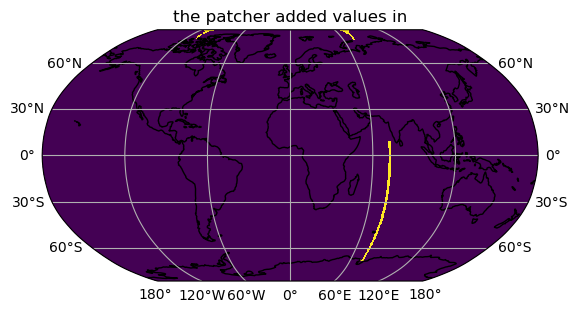

In [20]:
oet.plotting.plot.plot_da(ds_ssp_patched['patched_data'], add_colorbar=False)
plt.title('the patcher added values in')

### See for example this zoom in

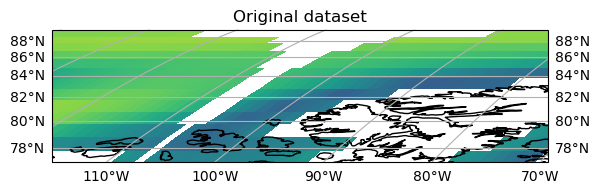

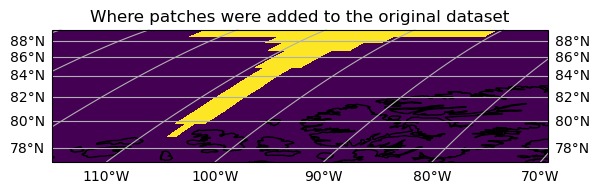

In [21]:
oet.plotting.plot.plot_da(ds_ssp['max jump'], add_colorbar=False)
plt.title('Original dataset')
plt.gca().set_extent([-115,-85,77,89.999])
plt.show()
oet.plotting.plot.plot_da(ds_ssp_patched['patched_data'], add_colorbar=False)
plt.title('Where patches were added to the original dataset')
plt.gca().set_extent([-115,-85,77,89.999])


# Why was patching needed?
You might have wondered by now how important it actually is to fill these gaps. We illustrate the difference in region finding applied to the original and the patched dataset. We clearly show the artifacts in the unpachted dataset

In [22]:
def silly_region_finding(ds):
    """Let's do something silly, let's return everything above the 10th percentile if there is a continuous region
    of at least 10^7 km^2 (10^13 m^2)"""
    reg=oet.region_finding.IterProductPercentiles(
        ds, 
        extra_opt=dict(iter_mask_min_area=1e13,
                       iterable_range=dict(product_percentiles=np.linspace(90,10,6))
                      ))
    masks, _ = reg.get_masks()
    return masks

In [23]:
def show_masks_from(ds, masks):
    plt.close()
    cmap = plt.cm.tab10 if len(masks)<=10 else plt.cm.tab20
    # Get an empty 2d DataArray
    merged_global_mask = ds["cell_area"].copy().astype(np.float64)
    merged_global_mask[:] = np.nan

    for i, mask in enumerate(masks):
        v = merged_global_mask.values
        v[mask] = i + 1
        merged_global_mask.data = v

    oet.plotting.plot.plot_da(
        merged_global_mask,
        cmap=cmap,
        vmin=-0.5,
        vmax=len(masks) + 0.5,
        cbar_kwargs=dict(orientation="horizontal", label="region number"),
    )

    used_numbers = np.arange(len(masks)) + 1

    plt.gcf().axes[1].set_xticks(ticks=used_numbers, labels=used_numbers, minor=False)
    plt.gcf().axes[1].set_xlim(used_numbers[0] - 0.5, used_numbers[-1] + 0.5)
    plt.title("Masked regions")

### Applying the silly region finding (return everything above the 10th percentile) to the unpatched dataset

Text(0.5, 1.0, 'Selected regions in non-patched datasets')

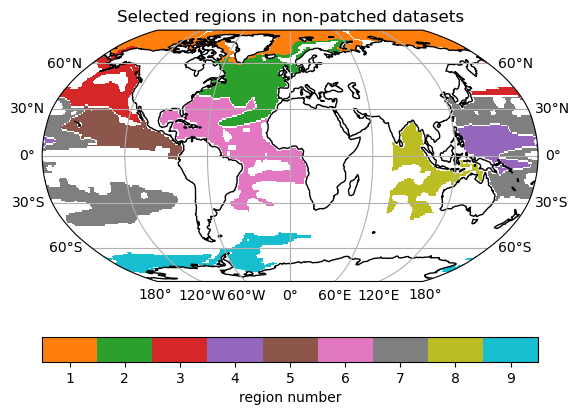

In [24]:
masks = silly_region_finding(ds_ssp)
show_masks_from(ds_ssp, masks)
plt.title('Selected regions in non-patched datasets')


### Applying the silly region finding to the patched dataset

Text(0.5, 1.0, 'Selected regions in patched datasets')

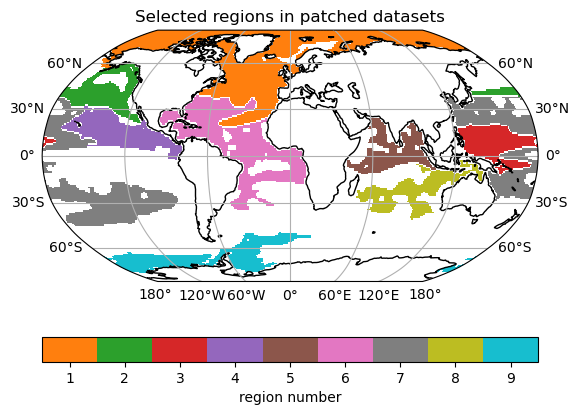

In [25]:
masks = silly_region_finding(ds_ssp_patched)
show_masks_from(ds_ssp_patched, masks)
plt.title('Selected regions in patched datasets')

# Conclusion
From the two figures above, it's clear why we added the patch:
  - region 5 (in the patched dataset) would be missed for the unpatched dataset
  - region 8 (in the patched dataset) would be chopped in two, right where the missing values are in the unpatched dataset.
  - (and somewhat lesser important) region 1/2 in we found in the unpatched dataset, can actually be seen as a single region. This is somewhat less relevant for most usecases since we would merge these regions most likely later anyway (see `example.ipynb`)

In [26]:
end = !date

In [27]:
datefmt = "%a %b %d %H:%M:%S %Z %Y"

print(f'Started at {start[0]}, finished at {end[0]}')
dt = datetime.datetime.strptime(end[0], datefmt) - datetime.datetime.strptime(
    start[0], datefmt
)
print(f'Took {dt.total_seconds()/60:.1f} m')

Started at Wed Apr 30 12:03:36 CEST 2025, finished at Wed Apr 30 12:04:08 CEST 2025
Took 0.5 m
